In [1]:
import numpy as np
import pandas as pd
import os

from imlp import iAct, iLoss, get_model
from dataloader import get_train_set_imlp, get_test_set_imlp, get_data

months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

Using TensorFlow backend.


In [2]:
data_set = 'Irish_2010'
path = os.path.abspath(os.path.join(os.getcwd(), '../..'))

data = get_data(path, data_set)

100%|██████████| 918/918 [00:29<00:00, 30.75it/s]


In [3]:
month = 1
n_clusters = 2
method = 'hierarchical/euclidean'

path_cluster = os.path.join(path, 'result', data_set, 'clustering', 'interval', method, f'n_clusters_{n_clusters}.csv')
clusters = pd.read_csv(path_cluster, header=None)

series = data[:, (month-1)*2:month*2, :months[month-1]*24]

In [6]:
error_train = []
error_test = []

for i in range(n_clusters):

    index = list(clusters[month-1] == i)
    sub_series = series[index]
    sub_series = np.sum(sub_series, axis=0)
    test = sub_series[:, -168:]
    train = sub_series[:, :-168]

    scale = np.zeros(2)
    scale[0] = np.max(train)
    scale[1] = np.min(train)
    train = (train - scale[1])/(scale[0] - scale[1])
    test = (test - scale[1])/(scale[0] - scale[1])

    # recency effect
    lag = 24
    d = 1

    trainX_c, trainX_r, trainY_c, trainY_r = get_train_set_imlp(train, lag, d)
    testX_c, testX_r, testY_c, testY_r = get_test_set_imlp(train, test, lag, d)

    # Parameters
    input_dim = lag + d
    output_dim = 1
    num_hidden_layers = 1
    num_units = [10]
    act = ['tanh']
    beta = 0.5

    # Get model
    model = get_model(input_dim, output_dim, num_units, act, beta, num_hidden_layers)

    # Train
    history = model.fit(x=[trainX_c, trainX_r], y=[trainY_c, trainY_r], epochs=800, verbose=0)

    pred_c, pred_r = model.predict(x=[trainX_c, trainX_r])
    e = np.sum((trainY_c - pred_c)**2) + np.sum((trainY_r - pred_r)**2)
    error_train.append(e)
    pred_c, pred_r = model.predict(x=[testX_c, testX_r])
    e = np.sum((testY_c - pred_c)**2) + np.sum((testY_r - pred_r)**2)
    error_test.append(e)
    del model
    break

40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [ ]:
model.save('model.h5')
model = load_model('model.h5', custom_objects={'iAct': iAct, 'loss': iLoss(beta).loss})

In [6]:
np.save('error_train.npy', np.array(error_train))
np.save('error_test.npy', np.array(error_test))

In [1]:
# import matplotlib.pyplot as plt
# %matplotlib inline

In [2]:
# import numpy as np

# error_train = np.load('error_train.npy')
# error_test = np.load('error_test.npy')

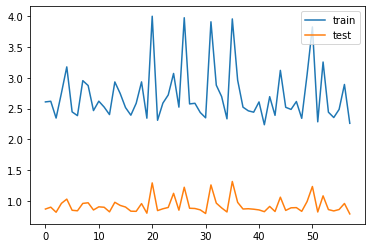

In [5]:
# plt.plot(error_train)
# plt.plot(error_test)
# plt.legend(['train', 'test'], loc='upper right')